In [1]:
# Evaluate all saved models on the test dataset
import glob, os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Tuple
import albumentations as A
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score


c:\Users\Priya\Downloads\kaggle\melanoma-project\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Paths
base_path = Path("../../../")
test_input_dir = base_path / "ISIC_2019_Test_Input"
gt_csv = base_path / "ISIC_2019_Test_GroundTruth.csv"

model_path = Path("../../model_training/working/melanoma_revisited_final_2.h5")
print("Found models:", )
model = load_model(model_path)

Found models:


In [3]:
# === Configuration ===
@dataclass
class PreprocessingConfig:
    """Configuration for the preprocessing pipeline"""

    target_size: Tuple[int, int] = (
        224,
        224,
    )
    clahe_clip_limit: float = 2.0
    clahe_grid_size: Tuple[int, int] = (8, 8)
    hair_removal_threshold: int = 10
    augmentation_probability: float = 0.5
    random_seed: int = 42


In [4]:
# === Image Preprocessing ===
class ImagePreprocessor:
    """Handles all image preprocessing steps for dermoscopic images"""

    def __init__(self, config: PreprocessingConfig):
        self.config = config
        self._setup_augmentation()

    def _setup_augmentation(self):
        """Setup augmentation pipeline using albumentations"""
        self.augmentation = A.Compose(
            [
                A.RandomRotate90(p=self.config.augmentation_probability),
                A.HorizontalFlip(p=self.config.augmentation_probability),
                A.ShiftScaleRotate(
                    shift_limit=0.0625,
                    scale_limit=0.1,
                    rotate_limit=45,
                    p=self.config.augmentation_probability,
                ),
                A.OneOf(
                    [
                        A.ElasticTransform(
                            alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5
                        ),
                        A.GridDistortion(p=0.5),
                        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
                    ],
                    p=0.3,
                ),
                A.OneOf(
                    [
                        A.GaussNoise(p=0.5),
                        A.RandomBrightnessContrast(p=0.5),
                        A.RandomGamma(p=0.5),
                    ],
                    p=0.3,
                ),
            ]
        )

    def remove_hair(self, image: np.ndarray) -> np.ndarray:
        """Remove hair from dermoscopic images using DullRazor algorithm"""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Apply blackhat morphology for hair detection
        kernel_sizes = [
            (7, 11),
            (11, 7),
            (9, 9),
        ]  # Vertical, horizontal, and square kernels
        mask = np.zeros_like(gray)

        for kernel_size in kernel_sizes:
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
            blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
            bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
            _, thresh = cv2.threshold(
                bhg, self.config.hair_removal_threshold, 255, cv2.THRESH_BINARY
            )
            mask = cv2.bitwise_or(mask, thresh)

        # Inpaint the hair regions
        result = cv2.inpaint(image, mask, 6, cv2.INPAINT_TELEA)
        return result

    def enhance_contrast(self, image: np.ndarray) -> np.ndarray:
        """Apply CLAHE for contrast enhancement"""
        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        la, a, b = cv2.split(lab)

        # Apply CLAHE to L channel
        clahe = cv2.createCLAHE(
            clipLimit=self.config.clahe_clip_limit,
            tileGridSize=self.config.clahe_grid_size,
        )
        cl = clahe.apply(la)

        # Merge channels and convert back to RGB
        enhanced = cv2.merge((cl, a, b))
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)
        return enhanced

    def normalize_image(self, image: np.ndarray) -> np.ndarray:
        """Normalize image to [0, 1] range"""
        return image.astype(np.float32) / 255.0

    def resize_image(self, image: np.ndarray) -> np.ndarray:
        """Resize image to target size"""
        return cv2.resize(image, self.config.target_size, interpolation=cv2.INTER_AREA)

    def apply_augmentation(self, image: np.ndarray) -> np.ndarray:
        """Apply data augmentation"""
        augmented = self.augmentation(image=image)
        return augmented["image"]

    def process_image(
        self, image: np.ndarray, apply_augmentation: bool = False
    ) -> np.ndarray:
        """Apply the complete preprocessing pipeline"""
        # Convert to RGB if image is in BGR format
        if image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply preprocessing steps
        image = self.remove_hair(image)
        image = self.enhance_contrast(image)
        image = self.resize_image(image)

        if apply_augmentation:
            image = self.apply_augmentation(image)

        # Normalize as the final step
        image = self.normalize_image(image)
        return image

In [5]:
def load_test_data_generator(
    input_dir: Path, gt_csv: Path, batch_size: int = 32
) -> Tuple[tf.data.Dataset, pd.DataFrame]:
    """Load test data using TensorFlow dataset for efficient lazy loading"""
    # Read ground truth CSV
    gt_df = pd.read_csv(gt_csv)
    gt_df.set_index("image", inplace=True)
    preprocessor = ImagePreprocessor(PreprocessingConfig())
    # Create a list of image paths and their corresponding labels
    image_paths = []
    labels = []

    for img_path in glob.glob(str(input_dir / "*.jpg")):
        image_name = os.path.basename(img_path).split(".")[0]
        label = gt_df.loc[image_name].values
        # Convert to binary (melanoma vs non-melanoma)
        label = (
            1 if label[0] == 1 else 0
        )  # Assuming melanoma is class 0 in original labels
        image_paths.append(img_path)
        labels.append(label)

    # Create TensorFlow dataset
    def load_and_preprocess_image(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.numpy_function(
            func=lambda x: preprocessor.process_image(x, apply_augmentation=False),
            inp=[image],
            Tout=tf.float32,
        )
        image.set_shape([224, 224, 3])
        return image

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(
        lambda x, y: (load_and_preprocess_image(x), y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, gt_df


# Load test data
test_dataset, gt_df = load_test_data_generator(test_input_dir, gt_csv)

c:\Users\Priya\Downloads\kaggle\melanoma-project\.venv\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Priya\AppData\Local\Temp\ipykernel_12132\4046792624.py:23: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
C:\Users\Priya\AppData\Local\Temp\ipykernel_12132\4046792624.py:27: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),


In [6]:
# Make predictions using the dataset
predictions = []
true_labels = []

for batch_images, batch_labels in test_dataset:
    batch_predictions = model.predict(batch_images, verbose=0)
    predictions.extend(batch_predictions[:, 0])  # Get probability for melanoma class
    true_labels.extend(batch_labels.numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

Classification Report:
              precision    recall  f1-score   support

Non-Melanoma       0.92      0.78      0.85      6911
    Melanoma       0.37      0.66      0.47      1327

    accuracy                           0.76      8238
   macro avg       0.64      0.72      0.66      8238
weighted avg       0.83      0.76      0.79      8238



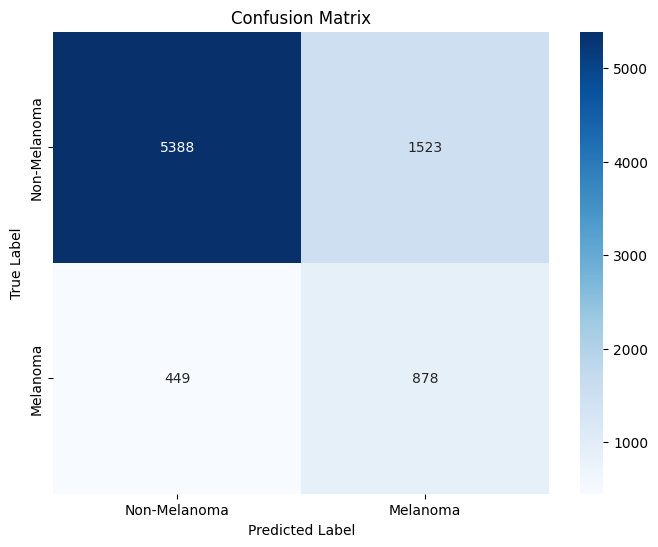

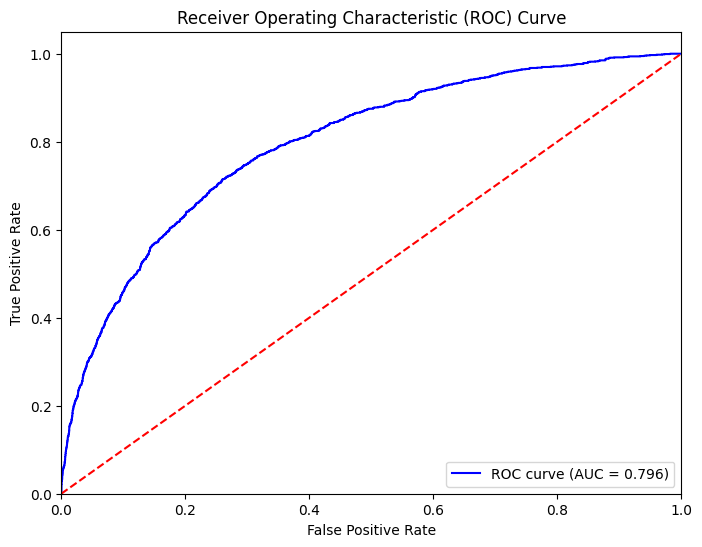

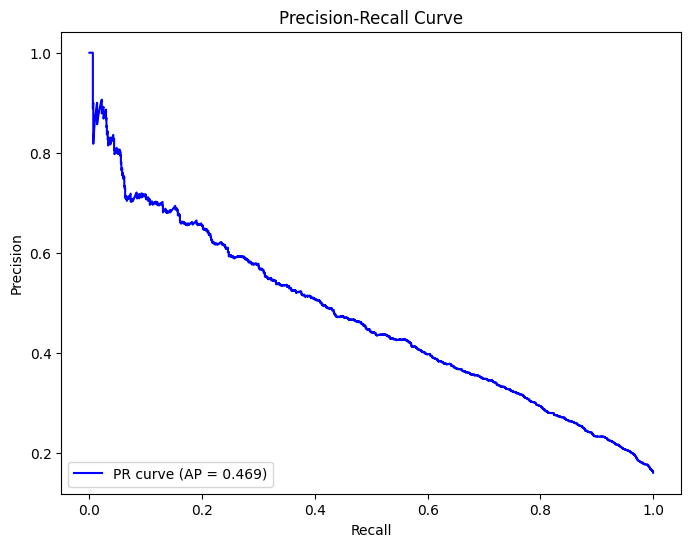

In [7]:
def evaluate_model(
    true_labels: np.ndarray, predictions: np.ndarray, predicted_labels: np.ndarray
) -> None:
    """Evaluate the model and print metrics for binary classification"""
    # Classification report
    print("Classification Report:")
    print(
        classification_report(
            true_labels, predicted_labels, target_names=["Non-Melanoma", "Melanoma"]
        )
    )

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Melanoma", "Melanoma"],
        yticklabels=["Non-Melanoma", "Melanoma"],
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    average_precision = average_precision_score(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(
        recall,
        precision,
        color="blue",
        label=f"PR curve (AP = {average_precision:.3f})",
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.show()


# Evaluate the model
evaluate_model(true_labels, predictions, predicted_labels)